In [1]:
import time
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as dset
from IPython.display import display, clear_output
from torch.autograd import Variable

ModuleNotFoundError: No module named 'torch'

In [14]:
def ETA(ep, epoch, i, bs, dt, total_bs):
    sec_left = (dt * (total_bs - i)) + dt * (epoch - ep) * (total_bs)
    #print(dt)
    #print(sec_left)
    #print(np.floor(sec_left / 3600), np.floor((sec_left%3600)/60),
    #              np.floor((sec_left%3600)%60))
    eta = "ETA: %d hours  %d min  %d sec" % (np.floor(sec_left / 3600),
                                            np.floor((sec_left%3600)/60),
                                            np.floor((sec_left%3600)%60))
    return eta

#---------------------------------------------------------------------
def status(batch_size, ep, epoch, i, loss, data_loader, eta):
    # status
    clear_output(wait=True)
    print(str(ep) + '/' + str(epoch), '\n',
          'batch: ' + str(i+1) + '/' + str(len(data_loader)) + 
             ' [' + '='*int((i+1)/(len(data_loader)/20)) +
              '>' + ' '*(20 - int((i+1)/(len(data_loader)/20))) +
              ']', '\n',
          'Loss: %.4g '% (loss), '\n',
          eta)
    
#---------------------------------------------------------------------
def showAllImages(x,y,z):
    x = x[1,:,:,:].detach()
    y = y[1,:,:,:].detach()
    z = z[1,:,:,:].detach()
    
    x = x.cpu()
    y = y.cpu()
    z = z.cpu()
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(np.transpose(x, (1,2,0)))
    plt.subplot(132)
    plt.imshow(np.transpose(y, (1,2,0)))
    plt.subplot(133)
    plt.imshow(np.transpose(z, (1,2,0)))
    plt.show()
    
#-------------------------------------------------------------------
# this function has been modified in order to accept only BW images
def showAllImagesBW(x,y,z):
    x = x[1,:,:,:].detach()
    y = y[1,:,:,:].detach()
    z = z[1,:,:,:].detach()
    
    x = x.cpu()
    x = x.squeeze()
    y = y.cpu()
    y = y.squeeze()
    z = z.cpu()
    z = z.squeeze()
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(x,cmap='gray')
    plt.subplot(132)
    plt.imshow(y)
    plt.subplot(133)
    plt.imshow(z)
    plt.show()

#-------------------------------------------------------------------
def conv4rnn(dimIn, dimOut):
    #print(dimIn,dimOut)
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.BatchNorm2d(dimOut)
    )
    return model    

#-------------------------------------------------------------------
def conv(dimIn, dimOut):
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.BatchNorm2d(dimOut),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(dimOut, dimOut, kernel_size=3, stride=1,
                 padding=1),
        nn.BatchNorm2d(dimOut)
    )
    return model

#-------------------------------------------------------------------
def pool():
    p = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return p

#-------------------------------------------------------------------
def invConv(dimIn, dimOut):
    model = nn.Sequential(
        nn.ConvTranspose2d(dimIn, dimOut, kernel_size=3, stride=2,
                           padding=1,output_padding=1),
        nn.BatchNorm2d(dimOut),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return model
    
#-------------------------------------------------------------------
def last(dimIn, dimOut):
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.Tanh()
    )
    return model

In [15]:
class convRNNcell(nn.Module):
    def __init__(self, inSize, inDim, hidSize):
        super().__init__()
        self.inSize = inSize
        self.hidSize = hidSize
        self.height, self.width = inDim
        
        self.conv = conv4rnn(self.inSize + self.hidSize,
                             2 * self.hidSize)
        
    def forward(self, xt, state):
        ht_1 = state
        
        concat = torch.cat([xt, ht_1], dim=1)
        conconv = self.conv(concat)
        ccx, cch = torch.split(conconv, self.hidSize, dim=1)
        ht = torch.tanh(ccx + cch)
        
        return ht
    
    def init_hidden(self, batchSize):
        state = (Variable(torch.zeros(batchSize, self.hidSize,
                                     self.height, self.width)))
        if torch.cuda.is_available():
            state = Variable(state).cuda(0)
        return state
    
#---------------------------------------------------------------------
class convRNN(nn.Module):
    def __init__(self, inSize, inDim, hidSize, layers, seqLen):
        super().__init__()
        self.inSize = inSize
        self.hidSize = hidSize
        self.height, self.width = inDim
        self.inDim = inDim
        self.layers = layers
        self.seqLen = seqLen
        
        cells= []
        for i in range(0, self.layers):
            dim = self.inDim if i == 0 else self.hidSize

            cells.append(convRNNcell(inSize=self.inSize,
                                     inDim=self.inDim,
                                     hidSize=self.hidSize))

        self.cells = nn.ModuleList(cells)
    
        
    def forward(self, img, state=None):
        xt = img
        state = self.init_hidden(img.size(0))

        for i in range(self.layers):
            ht = state
            
            for t in range(self.seqLen):
                ht = self.cells[i](xt, state=ht)
                
                #print(xt.shape, state.shape, ht.shape)
                #showAllImages(xt,state,ht)
                #time.sleep(0.5)
                
            state = ht
                         
        return ht
    
    def init_hidden(self, batchSize):
        initStates = []
        for i in range(self.layers):
            #print(self.cells[i])
            initStates = (self.cells[i].init_hidden(batchSize))
        return initStates


In [16]:
class RUNetGen(nn.Module):
    def __init__(self, filtersNum, hidSize, inDim):
        super().__init__()
        #self.dimIn = dimIn
        #self.dimOut = dimOut
        self.fil = filtersNum
        self.hidSize = hidSize
        self.inDim = inDim
        
        print("\n------Initializing RUNetGen------\n")
        
        self.conv1 = conv(3, self.fil)
        self.conR1 = convRNN(self.fil, self.inDim,
                             self.hidSize, layers=3, seqLen=3)
        self.rset1 = conv4rnn(self.hidSize, self.fil)
        self.pool1 = pool()
        self.conv2 = conv(self.fil, self.fil*2)
        self.conR2 = convRNN(self.fil*2, (int(self.inDim[0]/2),
                                        int(self.inDim[1]/2)),
                             self.hidSize*2, layers=3, seqLen=3)
        self.rset2 = conv4rnn(self.hidSize*2, self.fil*2)
        self.pool2 = pool()
        
        self.bridge = conv(self.fil*2, self.fil*4)
        
        self.inv1 = invConv(self.fil*4, self.fil*2)
        self.up1 = conv(self.fil*4, self.fil*2)
        self.inv2 = invConv(self.fil*2, self.fil)
        self.up2 = conv(self.fil*2, self.fil)
        
        self.last = last(self.fil, 3)
        
    def forward(self, img):
        conv1 = self.conv1(img)
        conR1 = self.conR1(conv1)
        rset1 = self.rset1(conR1)
        pool1 = self.pool1(rset1)
        conv2 = self.conv2(pool1)
        conR2 = self.conR2(conv2)
        rset2 = self.rset2(conR2)
        pool2 = self.pool2(rset2)
        
        bridge = self.bridge(pool2)
        
        inv1 = self.inv1(bridge)
        join1 = torch.cat([inv1, rset2],dim=1)
        up1 = self.up1(join1)
        inv2 = self.inv2(up1)
        join2 = torch.cat([inv2, rset1],dim=1)
        up2 = self.up2(join2)
        
        res = self.last(up2)
        return res


In [17]:
img_size = 256

img_dir = "./maps/"
trainset = dset.ImageFolder(root=img_dir,
                            transform = transforms.Compose([
                            transforms.Scale(size=img_size),
                            transforms.CenterCrop(size=(img_size,
                            img_size*2)),
                            transforms.ToTensor(),
                            ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, 
                                          num_workers=0)

In [18]:
file = './savedModels/RUNetSmall_256_bs2_lr0002_2.pth'

checkpoint = torch.load(file, map_location='cpu')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
lr = checkpoint['learningRate']
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

generator = nn.DataParallel(model)

In [19]:
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [20]:
print(epoch, loss)

10 tensor(0.0029, requires_grad=True)


In [21]:
with torch.no_grad():
    for i, (image, label) in enumerate(trainloader):
    
        ct, seg = torch.chunk(image, chunks=2, dim=3)
    
        x = Variable(ct)
        y_ = Variable(seg)
        y = generator.forward(x)
        
        clear_output(wait=True)
        showAllImages(x,y,y_)
        
        time.sleep(2)

AttributeError: 'RUNetGen' object has no attribute 'conR2'

## Da  qui in poi e' random

In [229]:
import cv2

In [230]:
a = checkpoint['optimizer_state_dict']
#b = a['state']
#c = a['state'][139727803463144]['exp_avg']
#c = np.array(c)
#dim = list(c.shape)
#dim[2] = dim[2] + 2
#dim[3] = dim[3] + 2
#dim = tuple(dim)
#print(a['state'])

#cRes = np.zeros(dim)

#for i in range(dim[0]):
#    cSlice = c[i,0,:,:].squeeze()
#    #print(cSlice.shape, cSlice)
#    cRes[i,0,:,:] = cv2.resize(cSlice, (dim[2],dim[3]),
#                               interpolation = cv2.INTER_LINEAR)

    
    
#print(cRes.shape, cRes)

newDict = a

for k in a['param_groups'][0]['params']:
    c = a['state'][k]['exp_avg']
    c = np.array(c)
    dim = list(c.shape)
    if len(dim) == 4:
        dim[2] = dim[2] + 2
        dim[3] = dim[3] + 2
        dim = tuple(dim)
        cRes = np.zeros(dim)
        for i in range(dim[0]):
            for j in range(dim[1]):
                cSlice = c[i,j,:,:].squeeze()
                #print(cSlice.shape, cSlice)
                cRes[i,0,:,:] = cv2.resize(cSlice, (dim[2],dim[3]), interpolation = cv2.INTER_LINEAR)
        newDict['state'][k]['exp_avg'] = cRes
    
        c = a['state'][k]['exp_avg_sq']
        c = np.array(c)
        dim = list(c.shape)
        dim[2] = dim[2] + 2
        dim[3] = dim[3] + 2
        dim = tuple(dim)
        cRes = np.zeros(dim)
        for i in range(dim[0]):
            for j in range(dim[1]):
                cSlice = c[i,j,:,:].squeeze()
                #print(cSlice.shape, cSlice)
                cRes[i,0,:,:] = cv2.resize(cSlice, (dim[2],dim[3]), interpolation = cv2.INTER_LINEAR)
        newDict['state'][k]['exp_avg_sq'] = cRes


# gotta change cRes in torch tensors. BOTH!


for i in a['param_groups'][0]['params']:
    #print(i)
    print(a['state'][i]['exp_avg'].shape,
          a['state'][i]['exp_avg_sq'].shape)
    

(24, 1, 5, 5) (24, 1, 5, 5)
torch.Size([24]) torch.Size([24])
torch.Size([24]) torch.Size([24])
torch.Size([24]) torch.Size([24])
(24, 24, 5, 5) (24, 24, 5, 5)
torch.Size([24]) torch.Size([24])
torch.Size([24]) torch.Size([24])
torch.Size([24]) torch.Size([24])
(48, 24, 5, 5) (48, 24, 5, 5)
torch.Size([48]) torch.Size([48])
torch.Size([48]) torch.Size([48])
torch.Size([48]) torch.Size([48])
(48, 48, 5, 5) (48, 48, 5, 5)
torch.Size([48]) torch.Size([48])
torch.Size([48]) torch.Size([48])
torch.Size([48]) torch.Size([48])
(96, 48, 5, 5) (96, 48, 5, 5)
torch.Size([96]) torch.Size([96])
torch.Size([96]) torch.Size([96])
torch.Size([96]) torch.Size([96])
(96, 96, 5, 5) (96, 96, 5, 5)
torch.Size([96]) torch.Size([96])
torch.Size([96]) torch.Size([96])
torch.Size([96]) torch.Size([96])
(192, 96, 5, 5) (192, 96, 5, 5)
torch.Size([192]) torch.Size([192])
torch.Size([192]) torch.Size([192])
torch.Size([192]) torch.Size([192])
(192, 192, 5, 5) (192, 192, 5, 5)
torch.Size([192]) torch.Size([192])


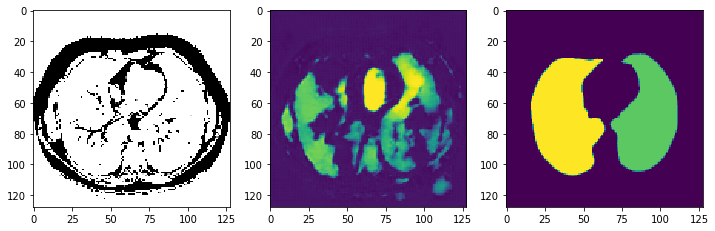

In [246]:
with torch.no_grad():
    for i, (image, label) in enumerate(trainloader):
    
        ct, seg = torch.chunk(image, chunks=2, dim=3)
    
        x = Variable(ct)
        y_ = Variable(seg)
        y = generator.forward(x)
        
        showAllImages(x,y,y_)
        break

In [237]:
a = checkpoint['optimizer_state_dict']
a['state'][140592886305632]['exp_avg'].shape
#newDict

(24, 1, 5, 5)

In [232]:
optimizer.load_state_dict(newDict)

TypeError: expected sequence object with len >= 0 or a single integer